# Adaptive Mesh Algorithm  
### Modelling of Stellar Spectra

Adaptive mesh [algorithm or refinement](https://en.wikipedia.org/wiki/Adaptive_mesh_refinement) or AMR is a numerical analysis method that provides a dynamic programming environment. This allows the programmer to refine the numerical grid or 'mesh' to optimzied the accuracy of the computation. 


The numerical analysis begins with a coarse grid where the spacing between parameters is large. In every iteration of the code, the grid space is refined until the most accurate model is obtained (This is measure in terms of reduced $\chi^2$ in this example).

In the following example, we will model the spectrum of an [AGB star](https://en.wikipedia.org/wiki/Asymptotic_giant_branch) with the simplification of a slab-model. This essentially means that we are replacing our star with a rectangular slab, followed by two layes of molecules in two separate slabs in front of it. This is shown in the following image: 

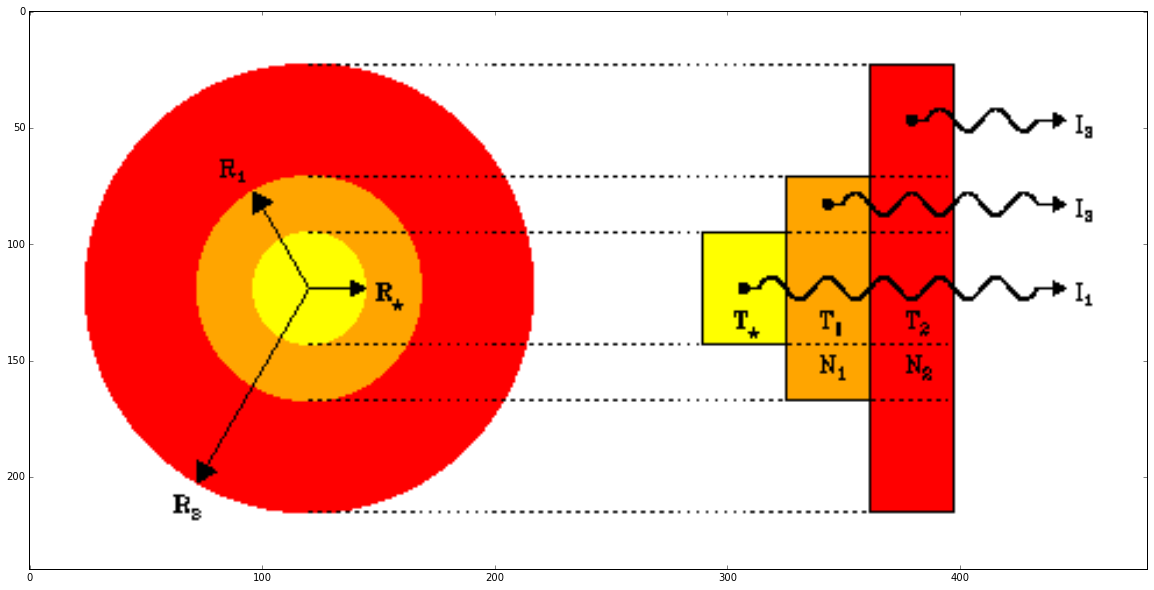


This figure illustrates how plane-parallel slab models can be used as an approximation to a spherical geometry when analyzing the molecular bands around AGB stars. The leftmost slab (yellow) represents the stellar photosphere; the other two slabs are molecular layers characterized by their own temperature and column densities of contributing species.
We are trying to see how the light that emerges from the central star interacts with the two molecular layers and model what the final beam of light really is going to be. 

In order for this, we will consider three cases.
1. The ray that emerged from the central star (yellow slab), gets absorbed by the second layer (orange) and then again gets absorbed by the third layer (red). This is shown as $I_1$ in the image. 

2. The ray that is emitted by the first molecular layer and is absorbed by the third layer. We call this $I_2$.

3. The ray that is emitted by the second molecular layer. We call this $I_3$.


In astrophysics the [*radiative transfer equation*](https://en.wikipedia.org/wiki/Radiative_transfer) formulates the interaction of light through a slab of material as follows: 

$I_\nu (s) = I_\nu (s_0) e^{-\tau_nu(s_0,s)} + \int_{s_0}^{s} j_\nu(s') e^{-\tau(s',s)}ds'$


#### Note that the following code is written in IDL(interactive data language) and uses Object Oriented approach. In IDL we use ; to comment out a line. For an introduction to IDL programming visit [this link](https://www.cfa.harvard.edu/~scranmer/Ay201a/Data/idl_basics.pdf). 

This code starts with a coarse grid consisting of three values (min, median, maximum) for the following eight variables:
1 - Temperature of the central star ($T_* = [2500,3500,4500]$) 

2 - Temperature of the first molecular layer ($T_1 = [500, 1500, 2500]$) 

3 - Temperature of the second molecular layer($T_2 = [500, 1500, 2500]$)

4 - Column density of water in the first layer ($\log N=[16,19,22]$)

5 - Column density of SiO in the first layer ($\log N=[16,19,22]$)

6 - Column density of water in the second layer ($\log N=[16,19,22]$)

7 - Column density of SiO in the second layer ($\log N=[16,19,22]$)

8 - Extinction coefficient in the Galactic Center region ($A_K = [0, 0.5, 1]$)


In the very first iteration, the code will use the earth-based data for the selected molecules to construct models with all these parameters to return the combination that results in the lowest $\chi^2$ value betwee nthe observed spectrum of the star and our earth-based models. 

In the second iteration, the code will pick the best parameter value for each, then divides the previous step size by two, and obtain a new numerical grid for every parameters and repeats the same apative behaviour until the lowest $\chi^2$ is obtained. Note that the code will end when the step size has reached the minimum user-specified value. 

PS: SiO and water are selected since literature contains various studies confirming the dominant presence of these molecules around the specific type of star that we are studying here. 

In [ ]:
PRO amr_refinement

; Test spectrafactory stuff. 
naked_stars = get_bulge_objects(/lowres,/naked_stars)


dir = '/export/...'
sf = obj_new('SF_Engine', use_approximation=1, resolution=90d0,oversample=2)
; This is the diretory in which this object is located "sf_engine__define.pro'
;directory = /export/home/sanaz/data/IDL/contrib/Jan/spectroscopy/SYNSPEC

chi2_dir = '/export/...'
minchi2 = 1d138
n_rays = 2

for counter=0,n_elements(naked_stars)-1 do begin
;for counter = 9,9 do begin 


oGrid = obj_new('JC_Grid')
oGrid->Add_Parameter,  'T_BB' , min=2500d0, max=4500d0, step=100d0 
oGrid->Add_Parameter,  'TT_1' , min=500d0, max=2500d0, step=100d0 
oGrid->Add_Parameter,  'LogNW1' , min=16d0, max=22d0, step=1d-1
oGrid->Add_Parameter,  'LogNS1' , min=16d0, max=22d0, step=1d-1
oGrid->Add_Parameter,  'TT_2' , min=500d0, max=2500d0, step=100d0 
oGrid->Add_Parameter,  'LogNW2' , min=16d0, max=22d0, step=1d-1
;oGrid->Add_Parameter,  'LogNS2' , min=16d0, max=22d0, step=1d-1
oGrid->Add_Parameter,  'AK_val' , min=0d0, max=1d0, step=1d-2


;-----------------------------------------------------------------------------------------------
; Doing all the calculations using GALACTIC Extinction Correction
;-------------------------------------------------------------------------------------------------
done  = 0
itr_counter = 0
while not done  do begin
print, done 
; ---- define the gridpoints  ----
 gridpoints = oGrid->GetCurrentGrid(status=status, itr_counter=itr_counter)


 if status eq 0 then done=1 else begin
   n_gridpar = n_tags(gridpoints)
   n_gridpoints = n_elements(gridpoints.(0))
   chi2_arr_gc = dblarr(n_gridpoints)


 for loop = 0,n_gridpoints-1 do begin 

  T_BB   = (gridpoints.T_BB)[loop]
  TT_1   = (gridpoints.TT_1)[loop]
  LogNW1 = (gridpoints.LogNW1)[loop]
  LogNS1 = (gridpoints.LogNS1)[loop]
  TT_2   = (gridpoints.TT_2)[loop]
  LogNW2 = (gridpoints.LogNW2)[loop]
;  LogNS2 = (gridpoints.LogNS2)[loop]
  AK_val = (gridpoints.AK_val)[loop]
 
; AK_val = get_bulge_info(object=naked_stars[counter],/CC_AK) 
; AK_val=get_bulge_info(object=naked_stars[counter],/Gonzalez_AK) ;for when we want to calculate model using the literature value

; We want to start the calculation only if the combination of above
;parameters is realistic, otherwise we will skip to the next model.

if TT_1 lt T_BB AND TT_2 lt TT_1 then begin
;if itr_counter ne 0 then print, 'doing it again'

 ; Applying the galactic center extinction correction
 spectrum = get_bulge_irs_spectrum(naked_stars[counter],$
                                  /extinction_corrected, AK=ak_val)
  wave = spectrum.wave
  flux = spectrum.flux
  err_gc = spectrum.err

sf->AdaptDataToGrid, wave=wave,flux=flux, $
                     outwave=gc_outwave,outflux=gc_outflux, /setrange, $
                     fullgrid=fullwavegrid,  idx_range=idx_range
usewave_gc = gc_outwave
useflux_gc = gc_outflux

idx_use_gc = where(usewave_gc GE 6d0 AND usewave_gc LE 14d0)


    I0 = B_nu(lambda=fullwavegrid, T=T_BB, engelke=0) 
   ; Now get an approximate absorption/emission model for layer 1
    sf->Get_Template_Model, molname=['H2O','SiO'], temperature=TT_1, $
                          logN=[LogNW1,LogNS1], I0=I0, absorption=I1, $
                           emission=I2, status=status   

    ; Add in a second layer. First, absorb some more in the center...
       sf->Get_Template_Model, molname=['H2O'], temperature=TT_2, $
                       logN=[LogNW2], I0=I1, absorption=I1_1, $
                       emission=I3, status=status  
      ; Then, absorb what was emitted in the first layer. Emission should be
       ; the same as the previous call, so no need to specify it. 
       sf->Get_Template_Model, molname=['H2O'], temperature=TT_2, $
                        logN=[LogNW2], I0=I2, absorption=I2_1, $
                        status=status
    
allcounter = 0L
tt0 = systime(1)

   if n_rays eq 2 then begin
   ymodel = [[I1_1[idx_range]],[I2_1[idx_range]]]
   endif else begin 
   ymodel = [[I1_1[idx_range]],[I2_1[idx_range]],[I3[idx_range]]]
   endelse 

   f_gc = get_nnls_factors(ydata=useflux_gc,ymodel=ymodel, sigma=err_gc, $
                           idx_use=idx_use_gc, yfit=yfit_gc, chi2=chi2_gc)
 
   n_par = n_gridpar + n_elements(f_gc)
   chi2_arr_gc[loop] = chi2_gc
   chi2_red_gc = chi2_gc/(n_elements(idx_use_gc)-n_par)
;  print, n_elements(idx_use_gc)


  Rs = (8.5d3*!cgs.pc)*(sqrt(4d0*f_gc[0]*1d-23/!dpi))
  R1 = (sqrt((f_gc[1]/f_gc[0])+1d0))
  if n_rays eq 2 then R2 = R1 else R2 = (sqrt((f_gc[2]/f_gc[0])+1d0))

want_plot = 1
if want_plot then begin 
       if chi2_gc LT minchi2 then begin
       minchi2=chi2_gc
       title_gc = strjoin(string(T_BB, TT_1, LogNW1, LogNS1,TT_2,$
                          LogNW2), '  ')
       checkwindow, 1
       plot, usewave_gc, useflux_gc, xr=[5, 40], yr=[0,max(useflux_gc > 0)],$
             yl = 0, xl = 1, title = title_gc, col=fsc_color('white')
       oplot_segments, usewave_gc, useflux_gc, idx_use_gc, $
                        col=fsc_color('limegreen')
       oplot, fullwavegrid, f_gc[0]*I1_1,  col=fsc_color('violet red')
       oplot, fullwavegrid, f_gc[1]*I2_1 ,  col=fsc_color('yellow')
       if n_rays eq 3 then begin
       oplot, fullwavegrid, f_gc[2]*I3 ,  col=fsc_color('orange') 
       endif 
       oplot, usewave_gc, yfit_gc, col=fsc_color('dodger blue')
       verplot, [6.5,7.5] , line=2, col=fsc_color('grey')    
 
       info = [textoidl('A_K  : ')+strcompress(AK_val),'',$
               textoidl('\chi^2: ')+strcompress(chi2_gc),'',$
               textoidl('\chi_{red}^2: ')+strcompress(chi2_red_gc),'',$
               replicate('Scale:',n_elements(f_gc))+strcompress(f_gc)]

      legend , [ naked_stars[counter]+ '- GALACTIC','R*: '+strcompress(Rs),$
                'R1: '+strcompress(R1)+' R*','R2: '+strcompress(R2)+' R*'] $
                ,/top, /right , col=fsc_color('white'), charsize= 1.4
      legend, info , /right, /center, col=fsc_color('white') ,charsize=1.5
   endif
    endif 
    endif  else begin
    chi2_arr_gc[loop] = 1d148
  endelse  
endfor 

   oGrid->Setchi2, chi2_arr_gc, gridpoints=gridpoints

endelse 


endwhile   

 
if n_rays eq 2 then  name = naked_stars[counter]+$
                     '_Galactic_Results_TwoRay_plainBB' 
if n_rays eq 3 then name = naked_stars[counter]+$
                     '_Galactic_Results_ThreeRay' 


struct = oGrid->GetFullArchive()
save, struct , filename= chi2_dir + name+'.sav'


;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;


save_plotsettings
k = setup_device(/ps,/color)
device, filename = chi2_dir+'contours/' +$
            naked_stars[counter] + '_contour.ps'
oGrid->PlotChi2Contour
device, /close 
set_plot, 'x'



oGRid->Reset
obj_destroy, oGrid


endfor 


END 


### The following are a few examples of the output models computed by this program. 

*Note*: The black spectrum is observed by Spitzer Space Telescope. The purple spectrum is the computed spectrum using the adaptive mesh algorithm, And the grey spectrum is the spectrum without the application of extinction correction. 

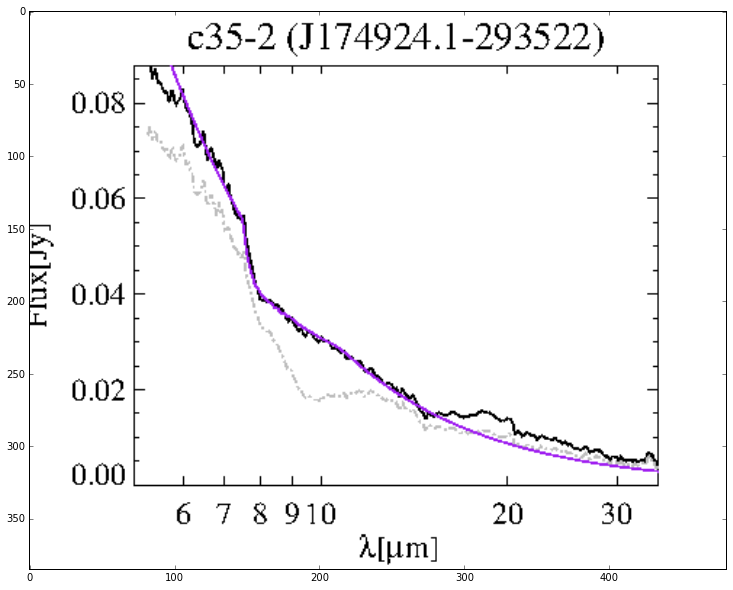

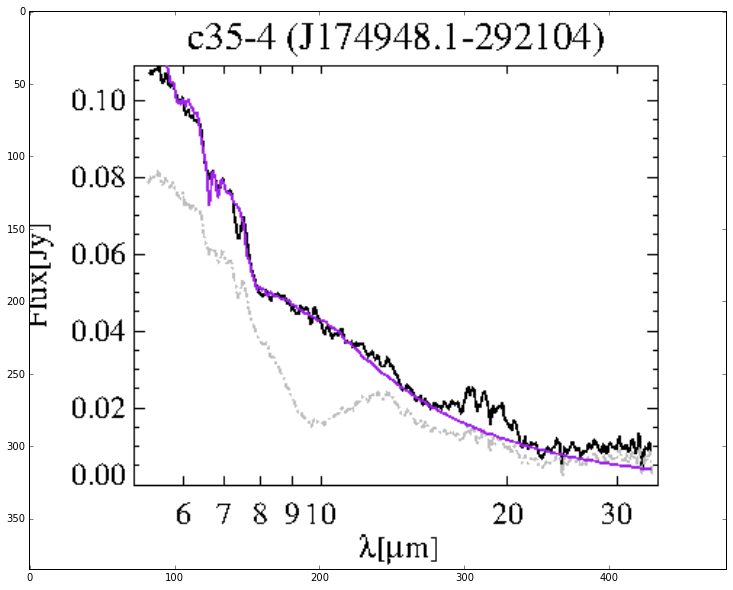

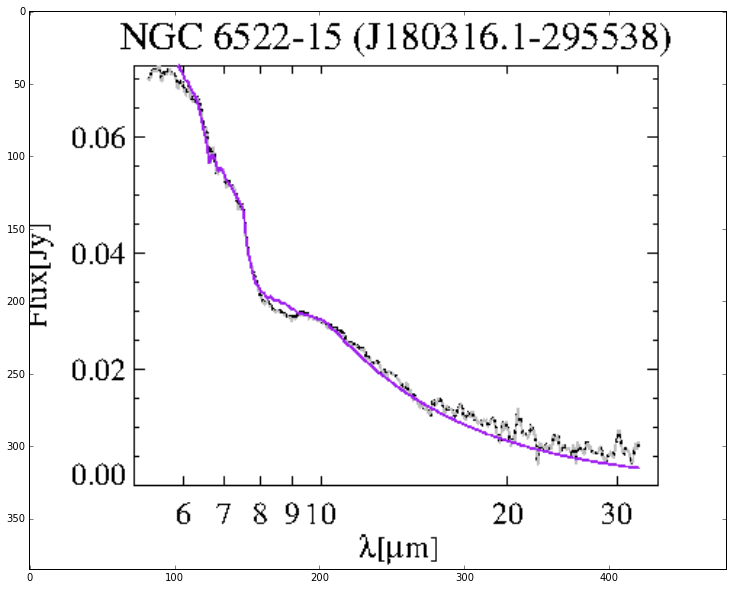

The table of results can be summarized as follows:

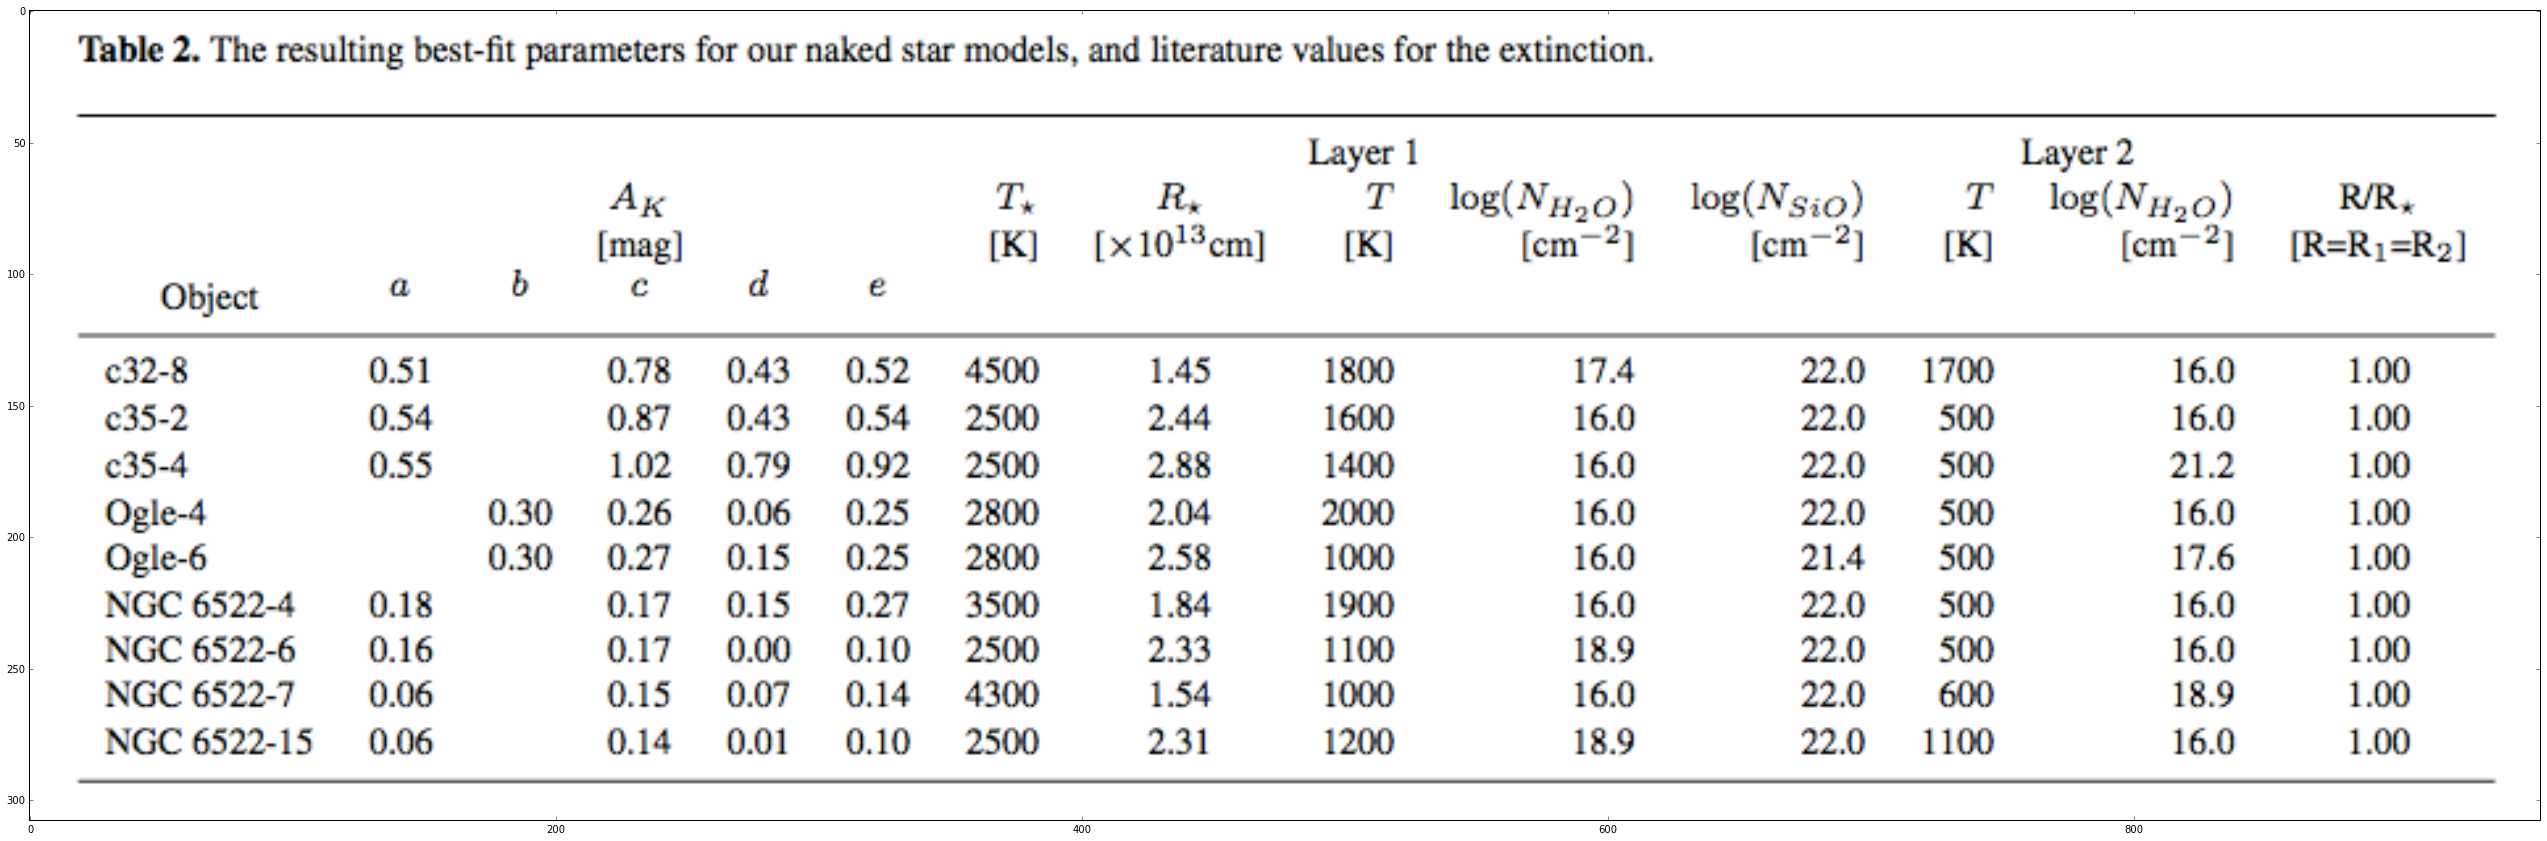

Which shows the final parameters for all the eight variable which correspond to the best model ($\chi^2_{min}$). The AMR together with OOP have been used to reduce the computation time by a significant amount. This code would have taken months to run, had it been written in the straight forward way. 

### For more example please take a look at the published article:
[Infrared spectroscopy of asymptotic giant branch stars in the Galactic bulge](http://mnras.oxfordjournals.org/search?submit=yes&submit=Search&pubdate_year=&volume=&firstpage=&doi=&author1=Golriz&author2=&title=&andorexacttitle=and&titleabstract=&andorexacttitleabs=and&fulltext=&andorexactfulltext=and&journalcode=mnras|mnrasl&fmonth=&fyear=&tmonth=&tyear=&flag=&format=standard&hits=10&sortspec=relevance&submit=yes)